<h1><center>More neural networks</center></h1>
<h2><center>Benedek Dankó</center></h2>

In [ ]:
# import required packages:

%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, callbacks
from keras.utils import to_categorical

#### 1. Load the CIFAR 10 dataset from the tf.keras.datasets API and train a LogisticRegression model on the dataset and predict all test outcomes with the sklearn API

In [ ]:
# download, split dataset:

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f'x_train shape: {x_train.shape}')
print(f'{x_train.shape[0]} train samples')
print(f'{x_test.shape[0]} test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


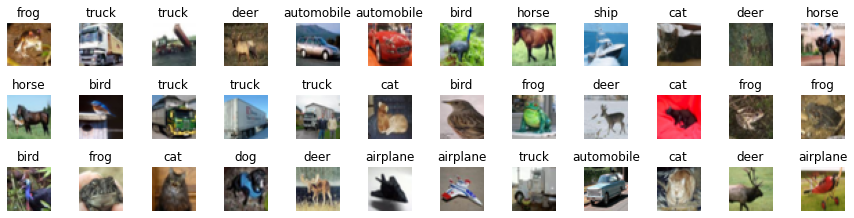

In [ ]:
# visualize randomly a few pictures:
cifar10classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 
                  5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
fig = plt.figure(1, (15., 4.))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 12), axes_pad=0.4)

for i in range(36):
    grid[i].imshow(x_train[i])
    grid[i].set_title(cifar10classes[y_train[i][0]])
    grid[i].axis('off')

In [ ]:
# "unpack" y arrays:
y_train = np.asanyarray([i[0] for i in y_train])
y_test  = np.asanyarray([i[0] for i in y_test])

# binarized version of the y arrays:
y_train_bin = preprocessing.label_binarize(y_train, classes=[0,1,2,3,4,5,6,7,8,9])
y_test_bin = preprocessing.label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
# convert, normalize x:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255 # normalize to fall between 0-1
x_test  /= 255

In [ ]:
# flatten x (this is needed for the elogistic regression model):
x_train_flat = np.asanyarray([i.flatten() for i in x_train])
x_test_flat = np.asanyarray([i.flatten() for i in x_test])

In [ ]:
# set up model, fit data:
clf = LogisticRegression(random_state=100, multi_class='multinomial', max_iter=150)
clf.fit(x_train_flat, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The `multi_class='multinomial'` option allows us to fit a logistic regression with more than 2 labels. <br>
If the multinomial option is chosen, then the cross-entropy loss function is used.

In [ ]:
# calculate multi-class AUC score:
pred = clf.predict_proba(x_test_flat)
lb = preprocessing.LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)

print(f'Multi-class AUC score: {metrics.roc_auc_score(y_test_lb, pred)}')

Multi-class AUC score: 0.8202158555555554


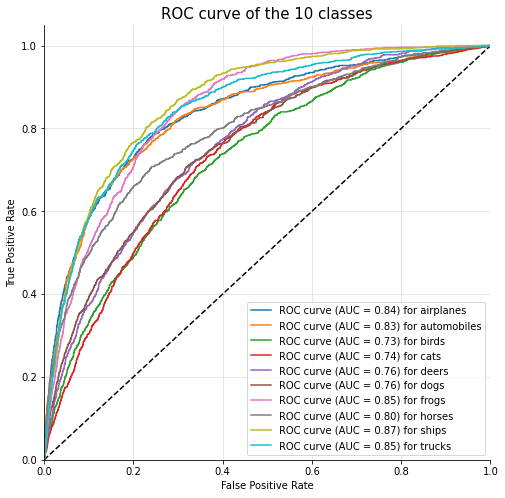

In [ ]:
# plot the ROC curve for each class on the same plot:
y_score = clf.decision_function(x_test_flat)

fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate dummies once
y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
for i in range(10):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# roc for each class
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve of the 10 classes', size=15)
for i in range(10):
    ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for %ss' % (roc_auc[i], cifar10classes[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
print(f'Model accuracy: {clf.score(x_test_flat, y_test)}')

Model accuracy: 0.4102


Based on these metrics, the logistic regression model does not seem so accurate on this dataset.

#### 2. Train an SGDClassifier regression model on the dataset and predict all the test outcomes with the sklearn API.

In [ ]:
# fit data to SGD model:
sgd = SGDClassifier(n_jobs=-1, loss='log')
sgd.fit(x_train_flat, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Here I chose the log loss function, because this way I am able to calculate ROC curves later. It is similar to Logisitic regression, so it should give similar results. <br>
In addition, log loss used in (multinomial) logistic regression or in derived models. Basically, log loss measures the performance of a classification model whose output is a probability value between 0 and 1 for a given class.

In [ ]:
pred = sgd.predict_proba(x_test_flat)

In [ ]:
print(f'Accuracy of the model: {sgd.score(x_test_flat, y_test)}')
print(f'Multi-class AUC score: {metrics.roc_auc_score(y_test_lb, pred)}')

Accuracy of the model: 0.3004
Multi-class AUC score: 0.7925358444444444


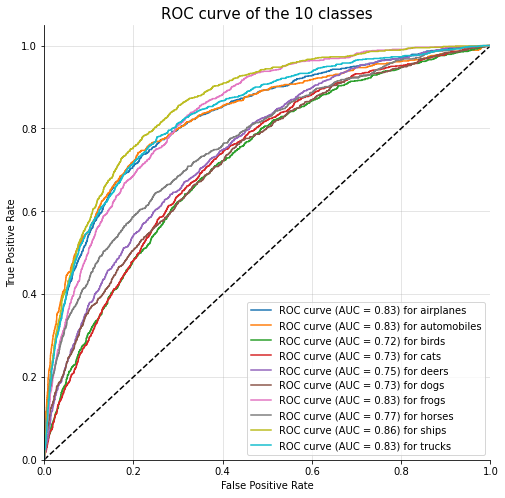

In [ ]:
# plot the ROC curves for each class:
y_score = sgd.decision_function(x_test_flat)

fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate dummies once
y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
for i in range(10):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# roc for each class
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve of the 10 classes', size=15)
for i in range(10):
    ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for %ss' % (roc_auc[i], cifar10classes[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
print(f'Model accuracy: {sgd.score(x_test_flat, y_test)}')

Model accuracy: 0.3004


This SGD model differs from the logistic regression that it uses a loss function, and the optimization method minimizes/maximizes it (e.g. gradient descent). Logistic regression does not use this kind of optimization.

#### 3. Train a RandomForest classifier

In [ ]:
# set up random forest model, fit data:
rf = RandomForestClassifier(random_state=42).fit(x_train_flat, y_train)

In [ ]:
y_score = rf.predict_proba(x_test_flat) 

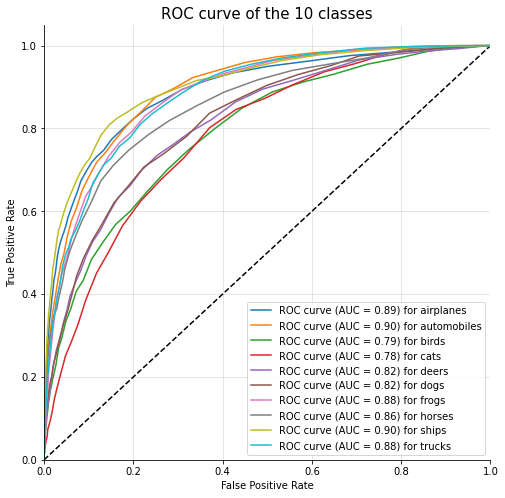

In [ ]:
# plot ROC curves:
fpr = dict()
tpr = dict()
roc_auc = dict()

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve of the 10 classes', size=15)
for i in range(10):
  fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:, i], y_score[:, i])
  ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for %ss' % (metrics.auc(fpr[i], tpr[i]), cifar10classes[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
pred = rf.predict_proba(x_test_flat)
print(f'Accuracy of the model: {rf.score(x_test_flat, y_test)}')
print(f'Multi-class AUC score: {metrics.roc_auc_score(y_test_lb, pred)}')

Accuracy of the model: 0.4654
Multi-class AUC score: 0.8525341444444445


The AUC scores are already better, for axample 0.9 for the ship, automobiles labels.

#### 4. Train a multi layer perceptron classifier

In [ ]:
# set up classifier, fit data:
clf = MLPClassifier(random_state=1, max_iter=30).fit(x_train_flat, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
y_score = clf.predict_proba(x_test_flat) 

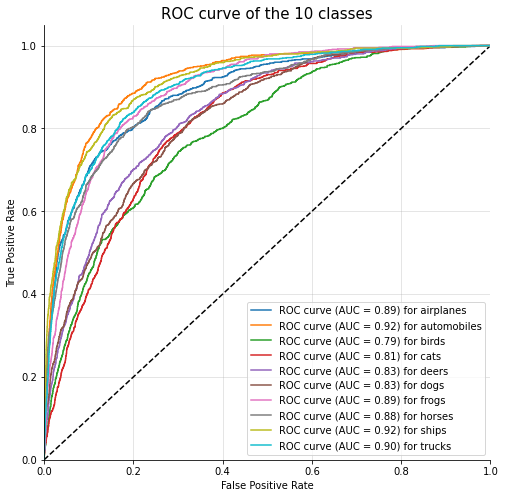

In [ ]:
# plot ROC curves:
fpr = dict()
tpr = dict()
roc_auc = dict()

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve of the 10 classes', size=15)
for i in range(10):
  fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:, i], y_score[:, i])
  ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for %ss' % (metrics.auc(fpr[i], tpr[i]), cifar10classes[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
pred = clf.predict_proba(x_test_flat)
print(f'Accuracy of the model: {clf.score(x_test_flat, y_test)}')
print(f'Multi-class AUC score: {metrics.roc_auc_score(y_test_lb, pred)}')

Accuracy of the model: 0.4739
Multi-class AUC score: 0.8663356666666667


It has already a better accuracy than the random forest, and a slightly better Multi-class AUC score.

#### 5. Train a ResNet50 CNN model on the dataset, utilize ImageNet pre-trained weights and fine-tune for at least 3 epochs.

Load again the dataset, just to have everything clean:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
y_train=to_categorical(y_train, 10) # convert ot categorical
y_test=to_categorical(y_test, 10)

In [ ]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255 # normalize to fall between 0-1
x_test  /= 255

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)
 
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(32)

My CNN model, built on the tensorflow keras ResNet50 model:

In [ ]:
# Functional TensorFlow API
def my_own_model(trainable=True):
  resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))
  resnet_base.trainable = trainable  # let it tune the ResNet50 parameters too
  model = models.Sequential()
  model.add(resnet_base)
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(2048, activation='relu'))
  model.add(layers.Dense(10, activation = 'softmax'))
  return model

In [ ]:
model = my_own_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_28 (Dense)             (None, 10)                20490     
Total params: 27,804,554
Trainable params: 27,751,434
Non-trainable params: 53,120
_________________________________________________________________


Compile, fit model with 10 epochs:

In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_dataset, batch_size=32, epochs=10, validation_data=test_dataset)

Epoch 1/10
1563/1563 [==============================] - 100s 64ms/step - loss: 1.3225 - accuracy: 0.5625 - val_loss: 0.8258 - val_accuracy: 0.7261
Epoch 2/10
1563/1563 [==============================] - 100s 64ms/step - loss: 0.8089 - accuracy: 0.7289 - val_loss: 0.6695 - val_accuracy: 0.7732
Epoch 3/10
1563/1563 [==============================] - 100s 64ms/step - loss: 0.6332 - accuracy: 0.7875 - val_loss: 0.6255 - val_accuracy: 0.7905
Epoch 4/10
1563/1563 [==============================] - 100s 64ms/step - loss: 0.5037 - accuracy: 0.8315 - val_loss: 0.6149 - val_accuracy: 0.7994
Epoch 5/10
1563/1563 [==============================] - 100s 64ms/step - loss: 0.3945 - accuracy: 0.8672 - val_loss: 0.6108 - val_accuracy: 0.8129
Epoch 6/10
1563/1563 [==============================] - 100s 64ms/step - loss: 0.3118 - accuracy: 0.8940 - val_loss: 0.6521 - val_accuracy: 0.8071
Epoch 7/10
1563/1563 [==============================] - 100s 64ms/step - loss: 0.2568 - accuracy: 0.9146 - val_loss: 0

After all, the model reached 81% validation accuracy, which is quite good.<br>
Since we provided pre-trained weights, the model's accuracy reached its plateu already after a few epochs. <br>
The model could be further improved, adding some extras.